In [1]:
# !pip install torch
# !pip install fair-esm==2.0.0
# !pip install biopython>=1.78
# !pip install matplotlib>=3.10
# !pip install numpy>=1.26.4
# !pip install networkx>=3.4.2
# !pip install scipy>=1.15.2

## Setup Package, PLM and Reference Sequence

In [2]:
from fmd_evolution import *
import esm # to use the PLM ESM-2
import os # to process evaluation data from MSA file
import numpy # for evaluation of paths

In [3]:
# Source: https://github.com/facebookresearch/esm/tree/main?tab=readme-ov-file#esmfold
model, alphabet = esm.pretrained.load_model_and_alphabet("esm2_t33_650M_UR50D") 
batch_converter = alphabet.get_batch_converter()

In [4]:
modelSingleton = ModelSingleton(model=model,alphabet=alphabet,batch_converter=batch_converter)

In [5]:
reference_seq = 'TTSAGESADPVTATVENYGGETQVQRRQHTDIAFILDRFVKVKPKEQVNVLDLMQIPAHTLVGALLRTATYYFSDLELAVKHEGDLTWVPNGAPETALDNTTNPTAYHKEPLTRLALPYTAPHRVLATVYNGSSKYGDTSTNNVRGDLQVLAQKAERTLPTSFNFGAIKATRVTELLYRMKRAETYCPRPLLAIQPSDARHKQRIVAPAKQ'

In [6]:
# mutation strategy parameters
constrained_start = 138 # start of high variability region
constrained_end = 143 # end of high variability region
mh_iterations = 10 # for metropolis-hastings algorithm
top_k_percent = 0.02 # % of pool of 114 possible mutations

# evaluation strategy parameters
max_generations = 7

In [7]:
# reference seq parameters
segment = list(reference_seq)[constrained_start-1:constrained_end] # constrained segment to mutate
ref_seq_id = ''.join(segment)
ref_seq_id = "base"

In [8]:
for pos in range(constrained_start,constrained_end+1):
    print(f"Position {pos} : Amino Acid {segment[pos-constrained_start]}")

Position 138 : Amino Acid D
Position 139 : Amino Acid T
Position 140 : Amino Acid S
Position 141 : Amino Acid T
Position 142 : Amino Acid N
Position 143 : Amino Acid N


In [9]:
plm = ProteinLanguageModel()
fmd_sequence = plm.create_protein_sequence(id=ref_seq_id,sequence=reference_seq) # protein sequence object generator

## Evolve VP1 Reference Sequence Across 6 Highly Mutable Positions

In [10]:
mutation_strat = MetropolisHastings(iterations=mh_iterations, top_k_percent=top_k_percent, start_pos=constrained_start,end_pos=constrained_end) # to generate pool of mutations
eval_strat = EvaluationStrategy(root_sequence = fmd_sequence) # to score and to filter pool of mutations
evolution = Evolution(
    root_sequence = fmd_sequence,
    mutation_strategy = mutation_strat,
    evaluation_strategy = eval_strat,
    max_generations=max_generations)

In [11]:
evolution.evolve_sequence() 

Number of possible_mutations = 114
K mutations (pool size) = 2
Pool of potential mutations: [('S', 140, 'K'), ('N', 142, 'T')]
Parent: mutation:base, probability:0.80945, distance 0
Mutation accepted: S140K, probability: 0.81218, distance: 0.00056
Mutation accepted: N142T, probability: 0.81179, distance: 0.00054
Viable mutations: ['S140K', 'N142T']
Number of possible_mutations = 114
K mutations (pool size) = 2
Pool of potential mutations: [('T', 141, 'V'), ('D', 138, 'T')]
Parent: mutation:S140K, probability:0.81218, distance 0.00056
Mutation accepted: T141V, probability: 0.81265, distance: 0.00078
Mutation accepted: D138T, probability: 0.81041, distance: 0.00064
Viable mutations: ['T141V', 'D138T']
Number of possible_mutations = 114
K mutations (pool size) = 2
Pool of potential mutations: [('T', 139, 'P'), ('N', 142, 'E')]
Parent: mutation:T141V, probability:0.81265, distance 0.00078
Mutation accepted: T139P, probability: 0.81125, distance: 0.00105
Viable mutations: ['T139P']
Number o

In [12]:
# evolution.evolve_sequence() # positions are 0-indexed, adjusted later for graph, fitness landscape, mutation score z axis, y axis pos 1 (all possible aas), y pos 2 (same), order the aminoa cids correctly! using embeddings for what's similar/close

## Visualise Evolutionary Paths Generated for the VP1 Protein

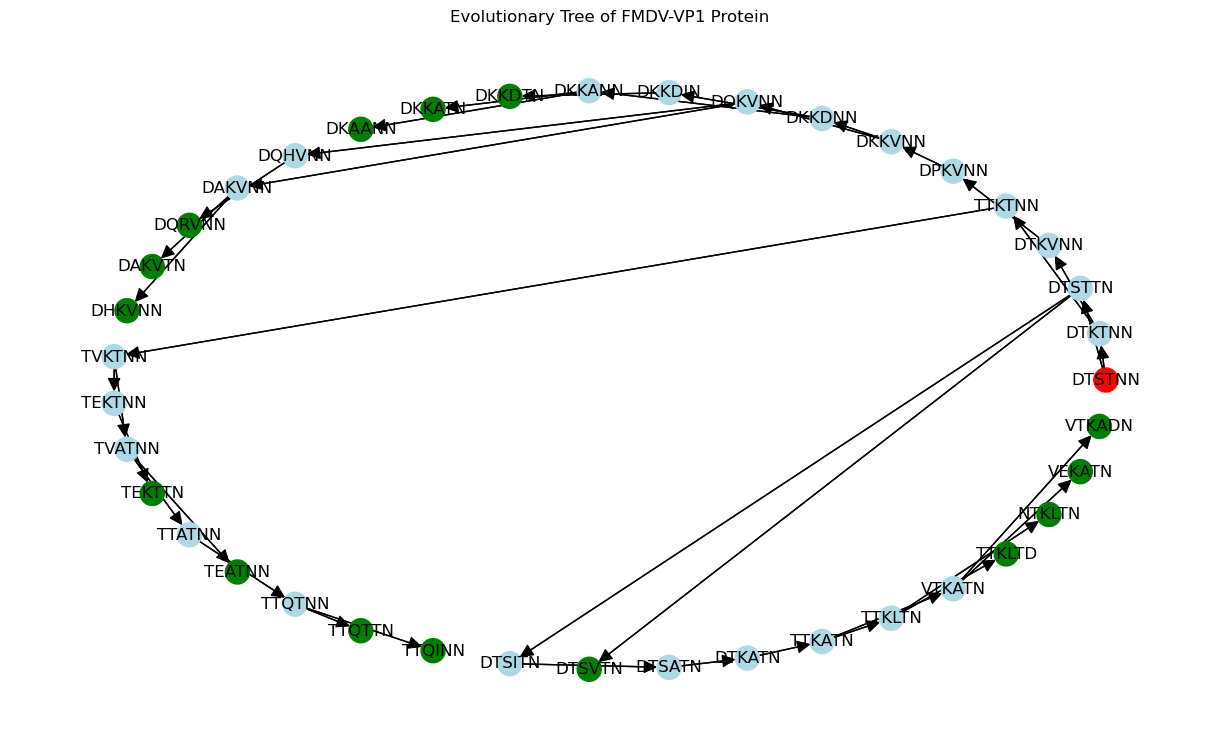

In [13]:
evolution.visualise_graph() 

In [14]:
paths = evolution.get_paths() # paths to leaf nodes only
num_of_paths = len(paths)
print(f"Number of paths generated: {num_of_paths}") # sorted by mean mutation score for path

Number of paths generated: 15


In [15]:
alignment_file_path = os.path.join("fmd_evolution/evaluation", "FMDV_VP1_HVR_1571seq_aln.fas") #  can I push this to my repo? or not supposed to be public?

evaluator = Evaluation(
    tree = evolution.G,
    alignment_file_path = alignment_file_path,
    start_pos = constrained_start,
    ref_seq_id = ref_seq_id
)

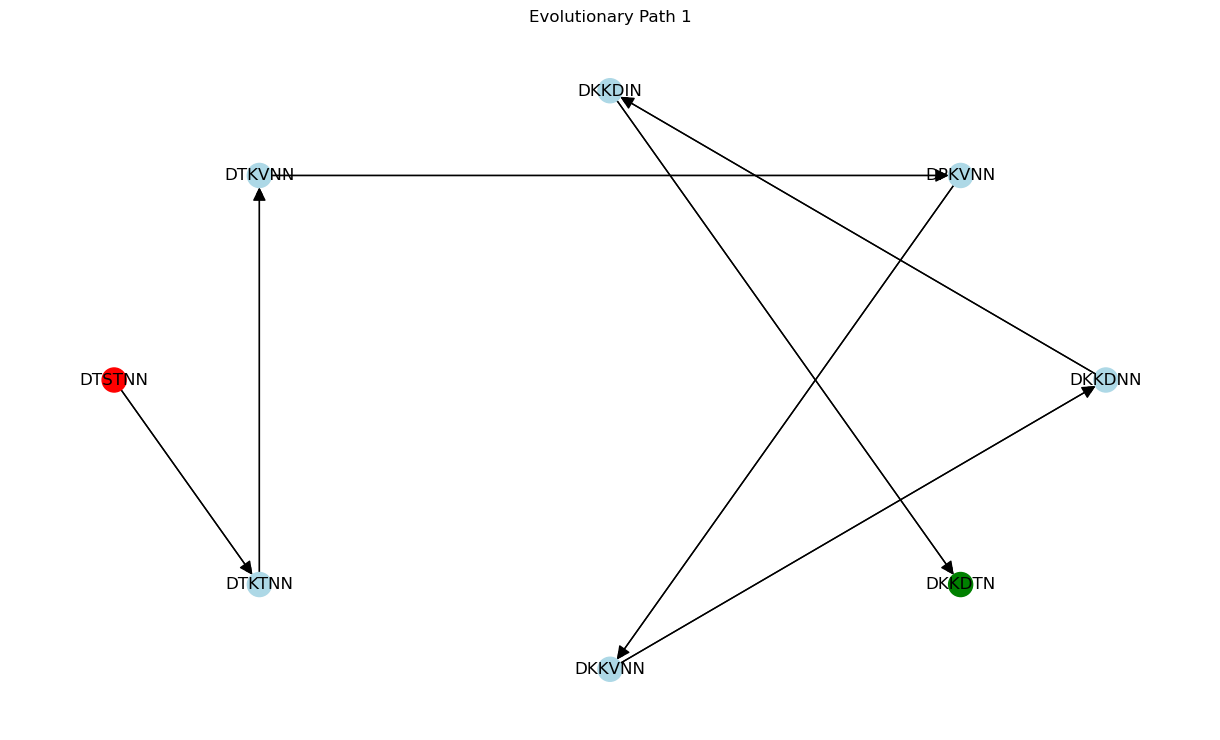

Path 1 as mutations: [None, 'S140K', 'T141V', 'T139P', 'P139K', 'V141D', 'N142I', 'I142T']


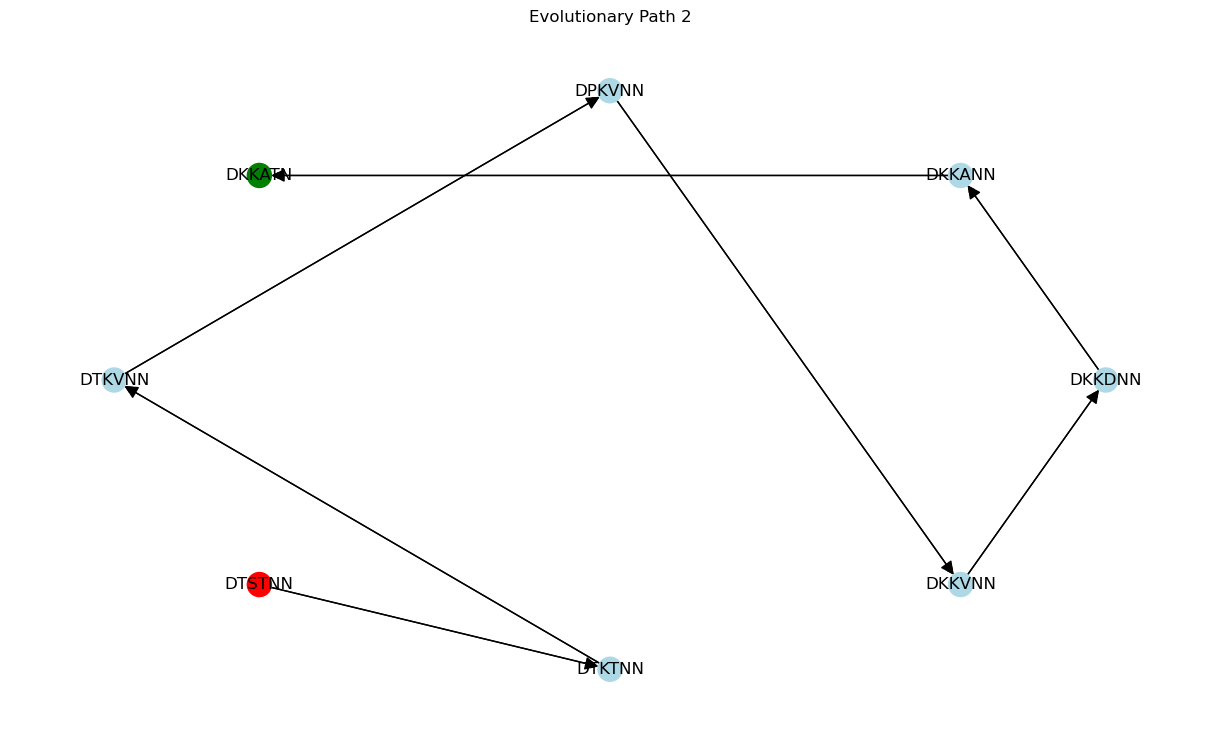

Path 2 as mutations: [None, 'S140K', 'T141V', 'T139P', 'P139K', 'V141D', 'D141A', 'N142T']


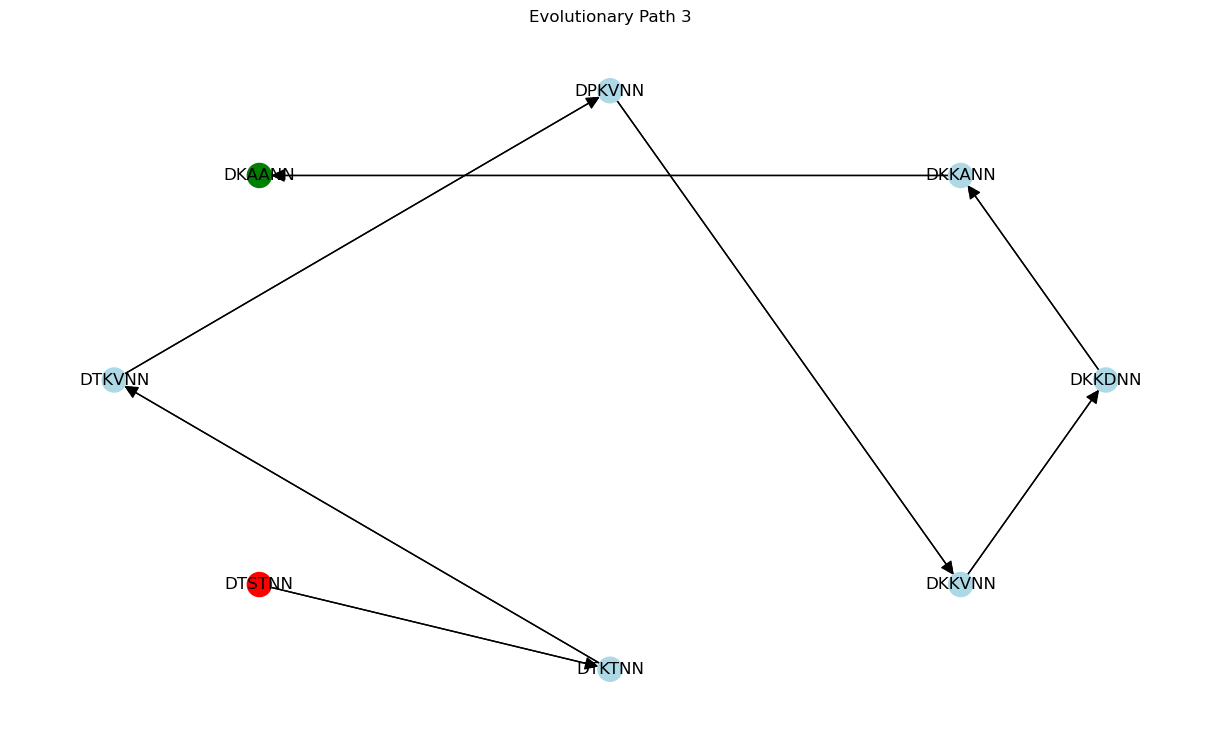

Path 3 as mutations: [None, 'S140K', 'T141V', 'T139P', 'P139K', 'V141D', 'D141A', 'K140A']


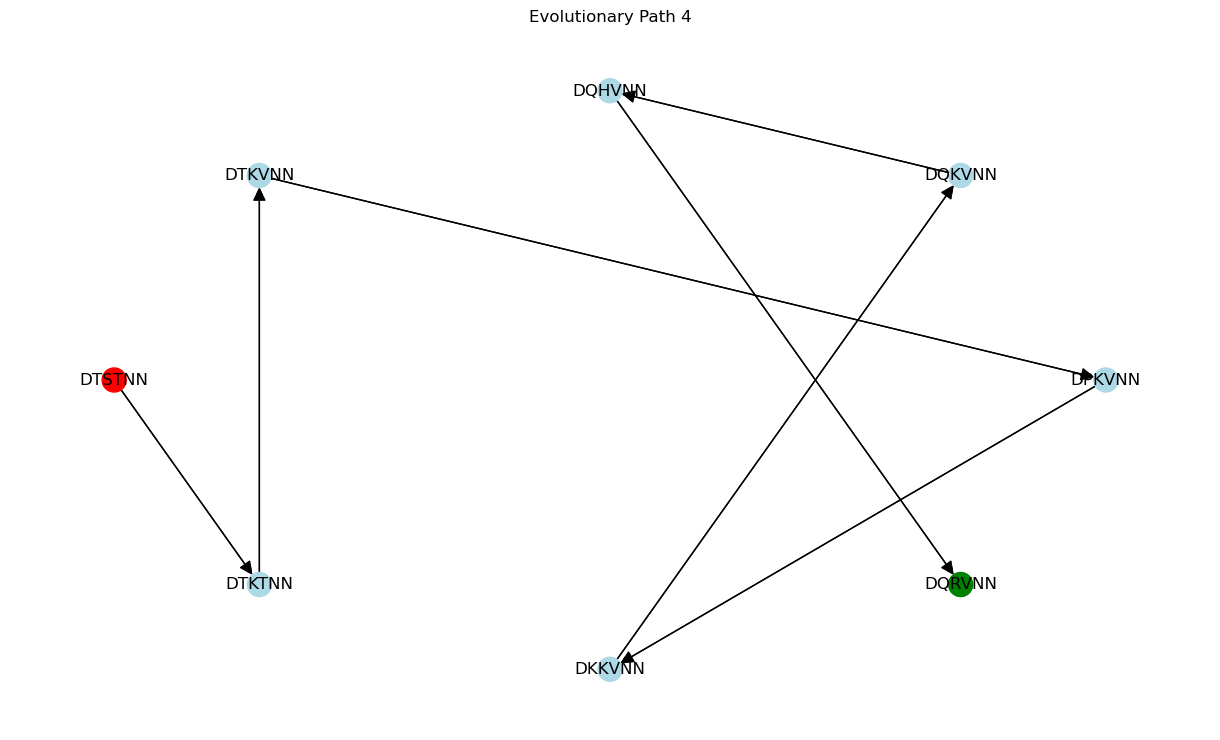

Path 4 as mutations: [None, 'S140K', 'T141V', 'T139P', 'P139K', 'K139Q', 'K140H', 'H140R']


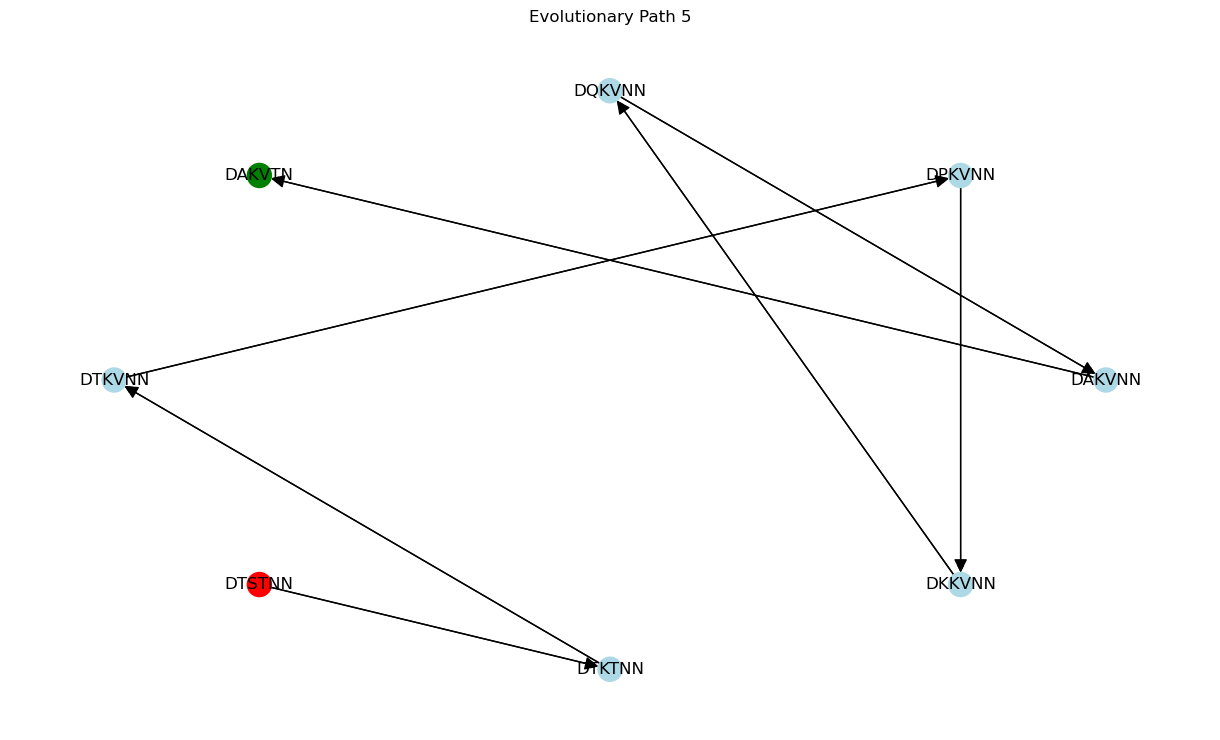

Path 5 as mutations: [None, 'S140K', 'T141V', 'T139P', 'P139K', 'K139Q', 'Q139A', 'N142T']


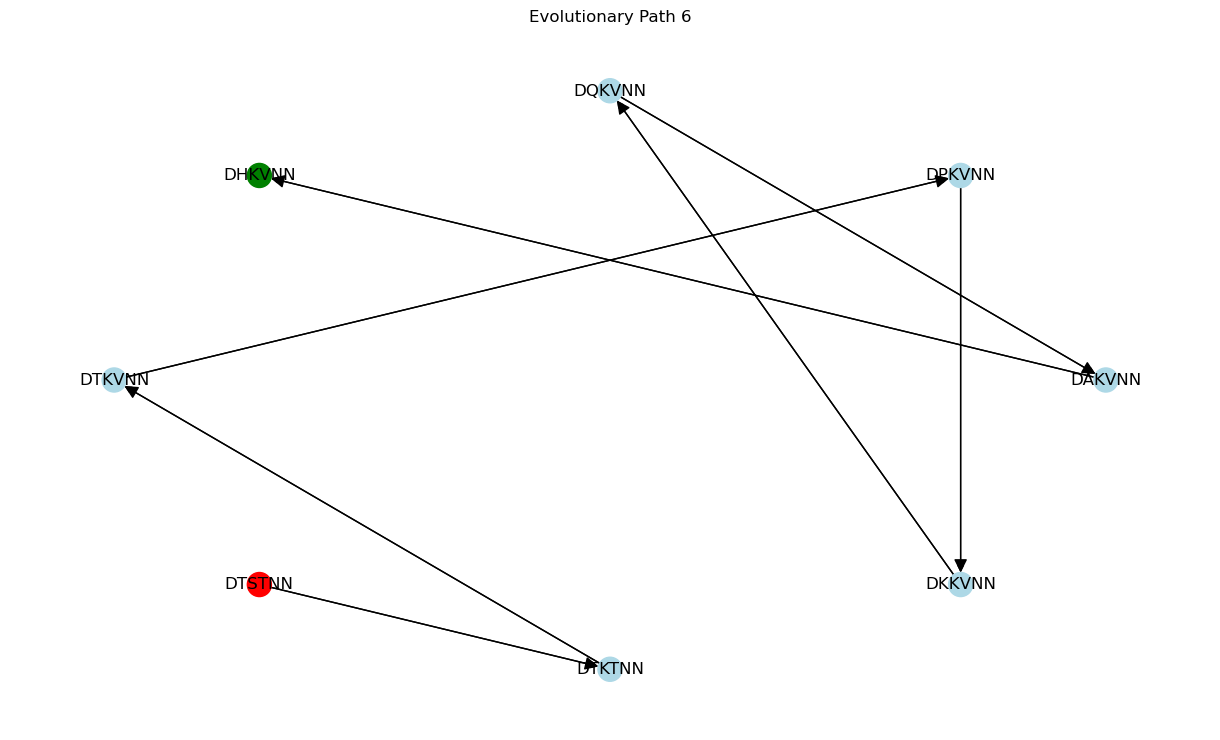

Path 6 as mutations: [None, 'S140K', 'T141V', 'T139P', 'P139K', 'K139Q', 'Q139A', 'A139H']


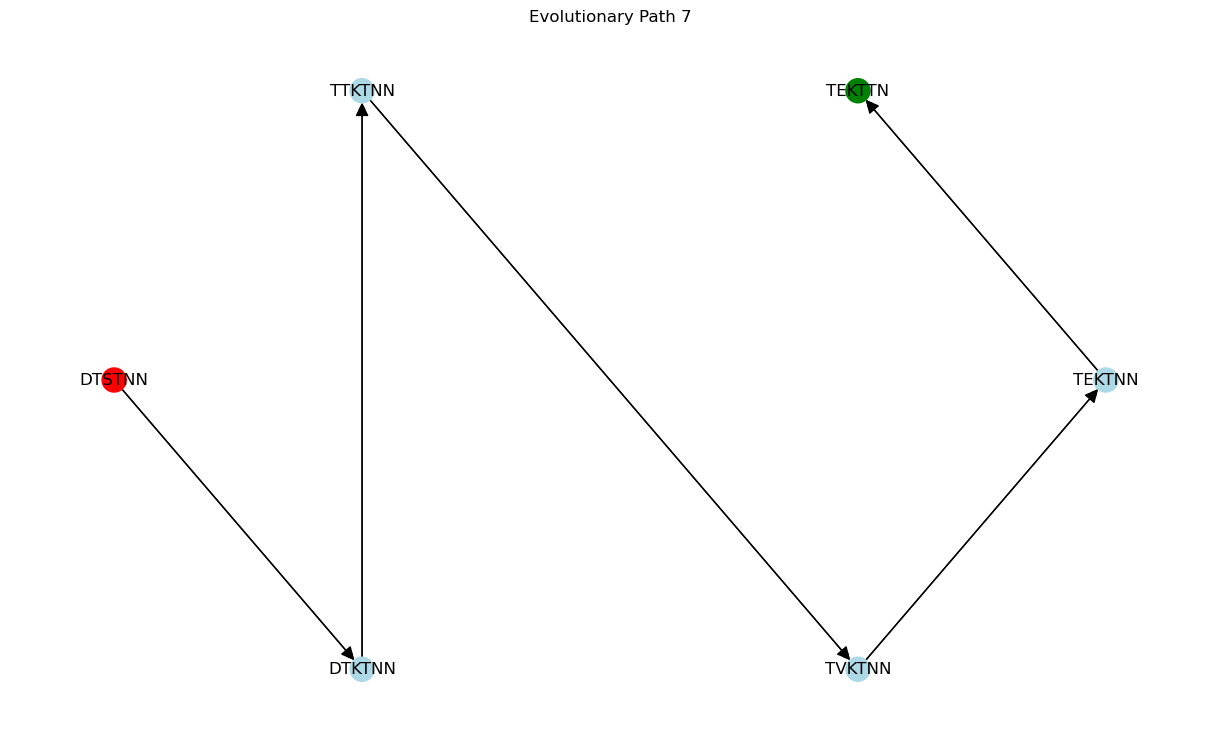

Path 7 as mutations: [None, 'S140K', 'D138T', 'T139V', 'V139E', 'N142T']


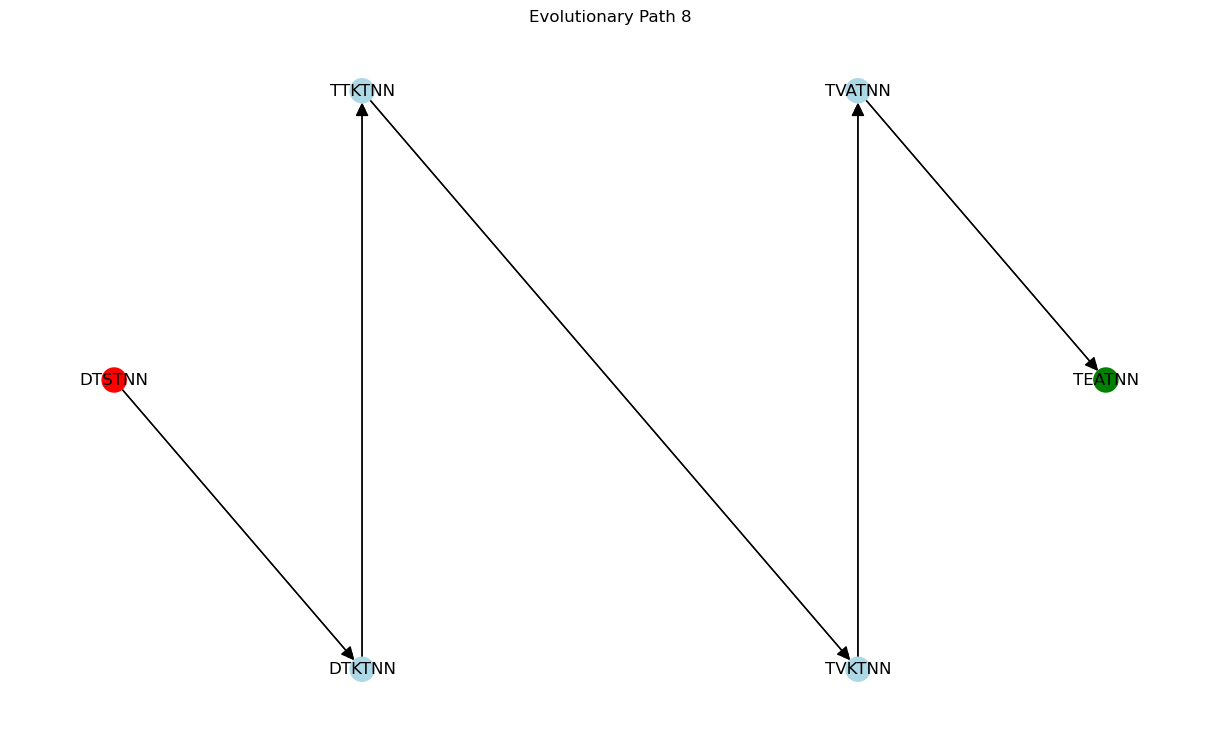

Path 8 as mutations: [None, 'S140K', 'D138T', 'T139V', 'K140A', 'V139E']


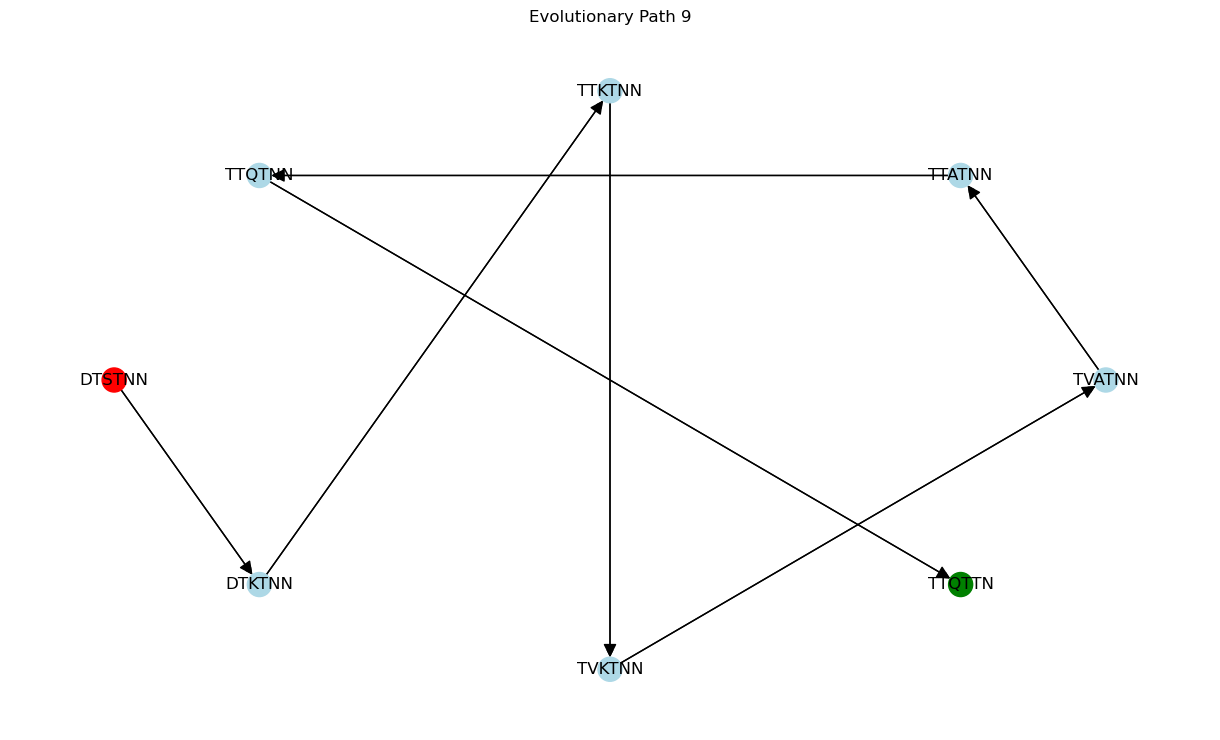

Path 9 as mutations: [None, 'S140K', 'D138T', 'T139V', 'K140A', 'V139T', 'A140Q', 'N142T']


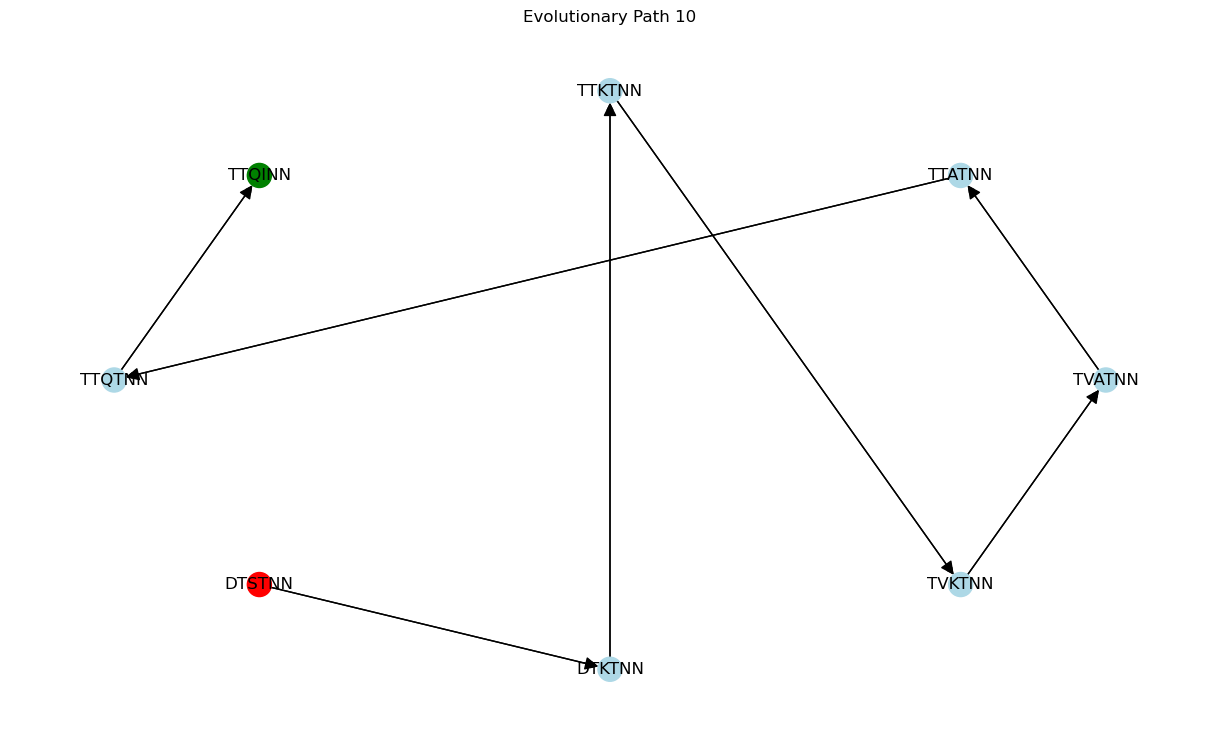

Path 10 as mutations: [None, 'S140K', 'D138T', 'T139V', 'K140A', 'V139T', 'A140Q', 'T141I']


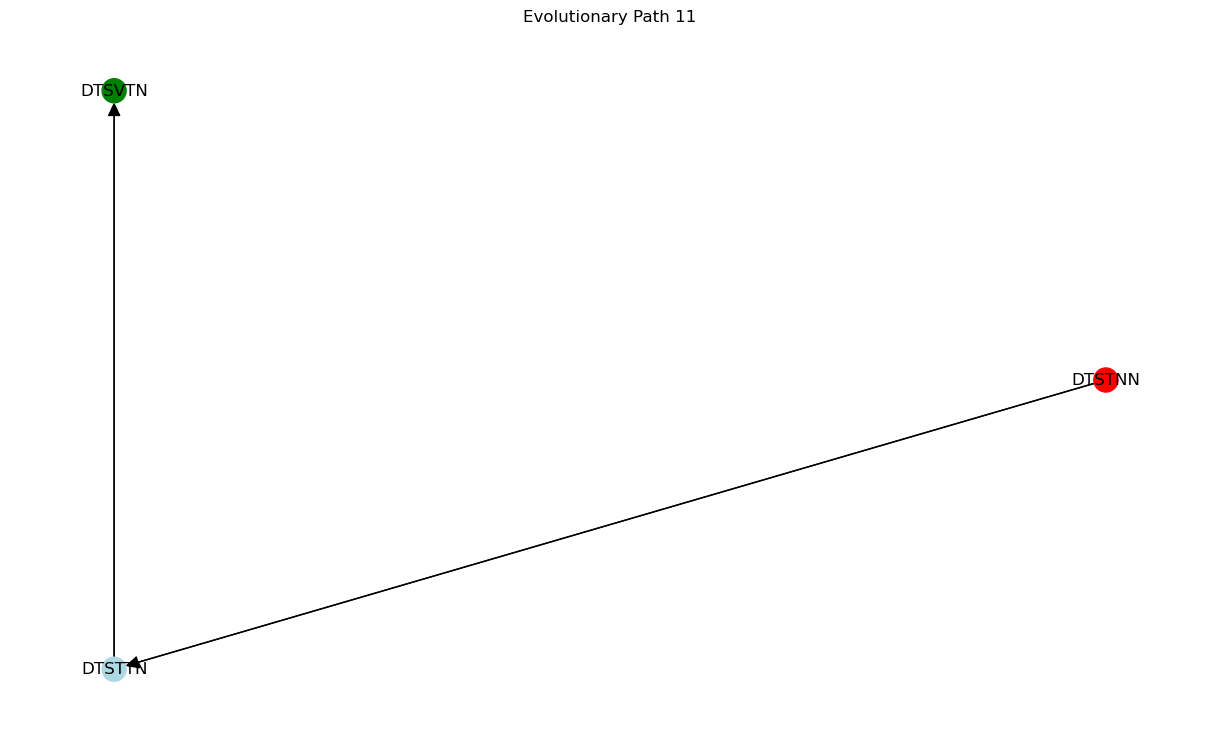

Path 11 as mutations: [None, 'N142T', 'T141V']


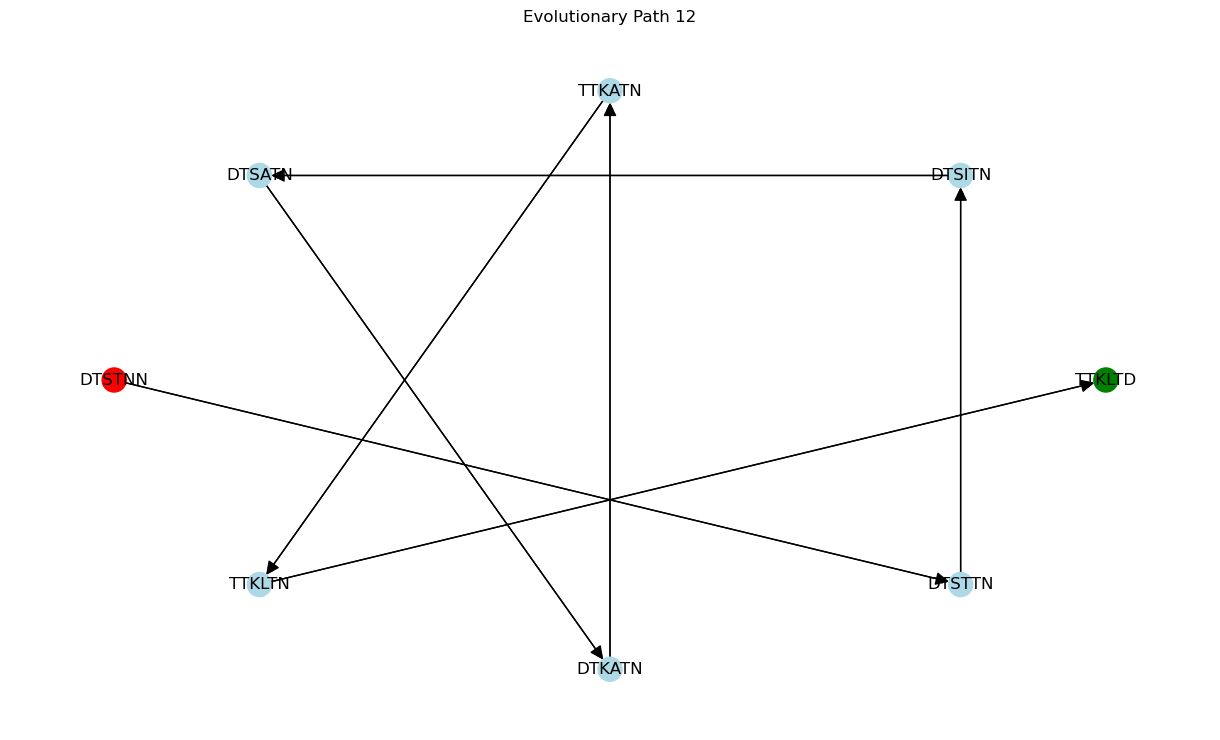

Path 12 as mutations: [None, 'N142T', 'T141I', 'I141A', 'S140K', 'D138T', 'A141L', 'N143D']


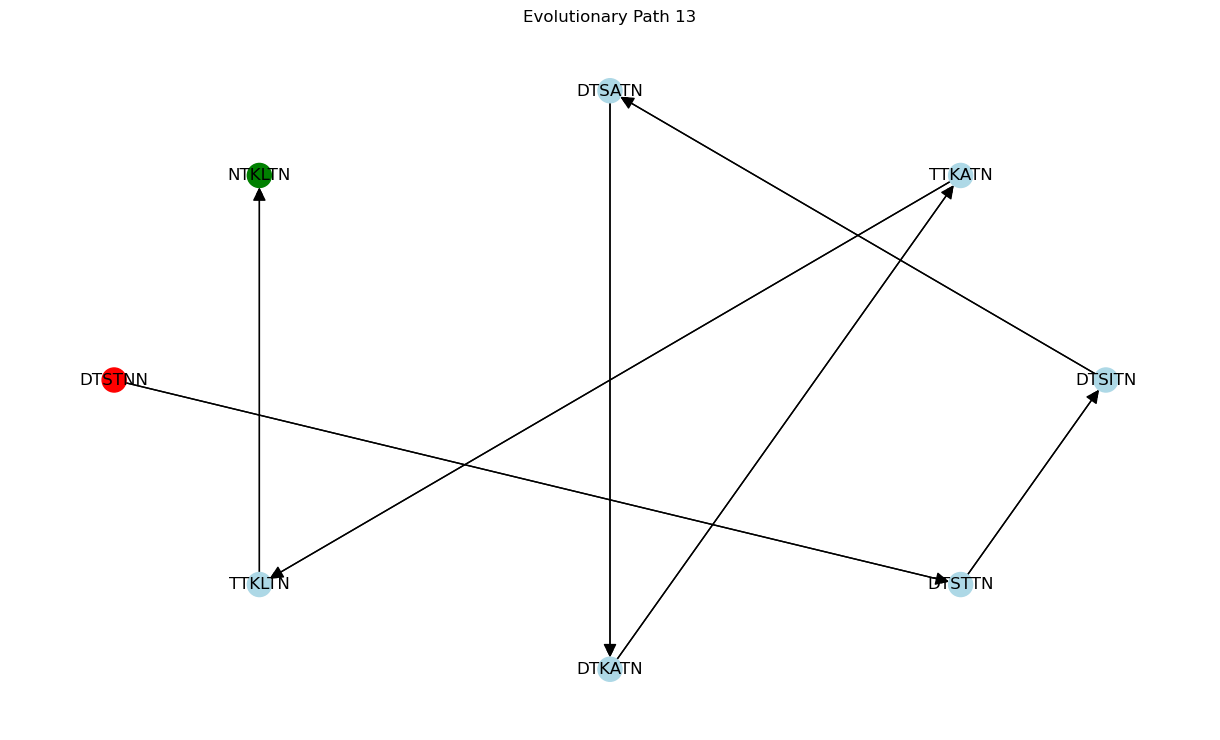

Path 13 as mutations: [None, 'N142T', 'T141I', 'I141A', 'S140K', 'D138T', 'A141L', 'T138N']


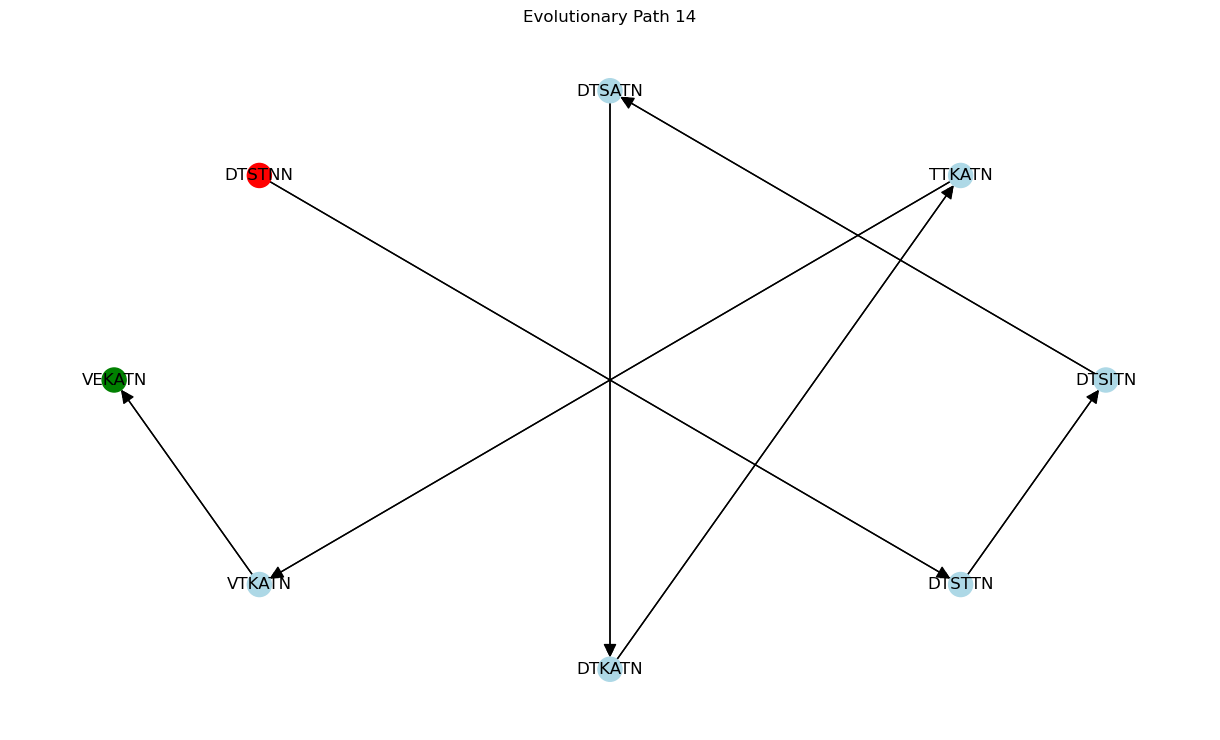

Path 14 as mutations: [None, 'N142T', 'T141I', 'I141A', 'S140K', 'D138T', 'T138V', 'T139E']


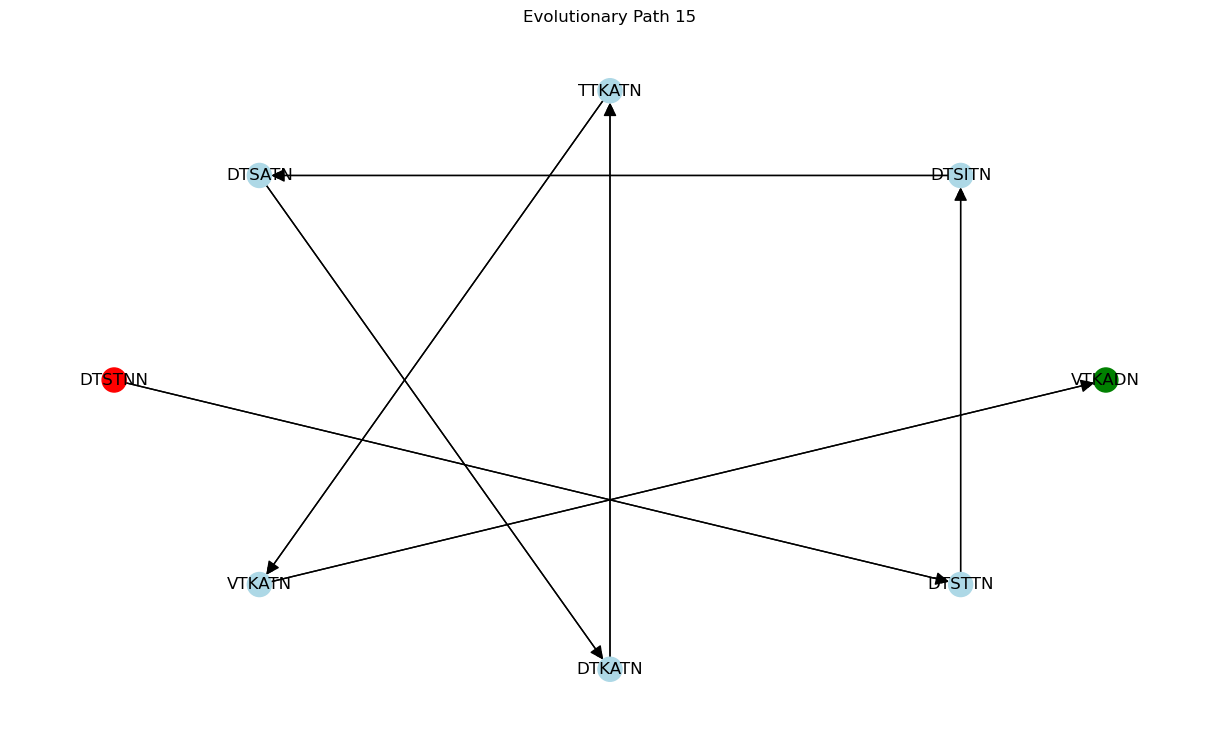

Path 15 as mutations: [None, 'N142T', 'T141I', 'I141A', 'S140K', 'D138T', 'T138V', 'T142D']


In [16]:
for i in range(num_of_paths):
    average_mutation_score,path = paths[i]
    path_name = i+1 # start from Path 1
    evolution.visualise_graph(path=path,title=f"Evolutionary Path {path_name}")
    path_as_mutations = evaluator.get_path_as_mutations(path)
    print(f"Path {path_name} as mutations: {path_as_mutations}")

## Evaluation of Predicted Evolutionary Paths Against MSA

In [17]:
paths_mutation_matches,paths_final_segment_matches,paths_consecutive_pair_matches = evaluator.get_paths_metric_data(paths)

Paths: [['DTKTNN', 'DTKVNN', 'DPKVNN', 'DKKVNN', 'DKKDNN', 'DKKDIN', 'DKKDTN'], ['DTKTNN', 'DTKVNN', 'DPKVNN', 'DKKVNN', 'DKKDNN', 'DKKANN', 'DKKATN'], ['DTKTNN', 'DTKVNN', 'DPKVNN', 'DKKVNN', 'DKKDNN', 'DKKANN', 'DKAANN'], ['DTKTNN', 'DTKVNN', 'DPKVNN', 'DKKVNN', 'DQKVNN', 'DQHVNN', 'DQRVNN'], ['DTKTNN', 'DTKVNN', 'DPKVNN', 'DKKVNN', 'DQKVNN', 'DAKVNN', 'DAKVTN'], ['DTKTNN', 'DTKVNN', 'DPKVNN', 'DKKVNN', 'DQKVNN', 'DAKVNN', 'DHKVNN'], ['DTKTNN', 'TTKTNN', 'TVKTNN', 'TEKTNN', 'TEKTTN'], ['DTKTNN', 'TTKTNN', 'TVKTNN', 'TVATNN', 'TEATNN'], ['DTKTNN', 'TTKTNN', 'TVKTNN', 'TVATNN', 'TTATNN', 'TTQTNN', 'TTQTTN'], ['DTKTNN', 'TTKTNN', 'TVKTNN', 'TVATNN', 'TTATNN', 'TTQTNN', 'TTQINN'], ['DTSTTN', 'DTSVTN'], ['DTSTTN', 'DTSITN', 'DTSATN', 'DTKATN', 'TTKATN', 'TTKLTN', 'TTKLTD'], ['DTSTTN', 'DTSITN', 'DTSATN', 'DTKATN', 'TTKATN', 'TTKLTN', 'NTKLTN'], ['DTSTTN', 'DTSITN', 'DTSATN', 'DTKATN', 'TTKATN', 'VTKATN', 'VEKATN'], ['DTSTTN', 'DTSITN', 'DTSATN', 'DTKATN', 'TTKATN', 'VTKATN', 'VTKADN']]


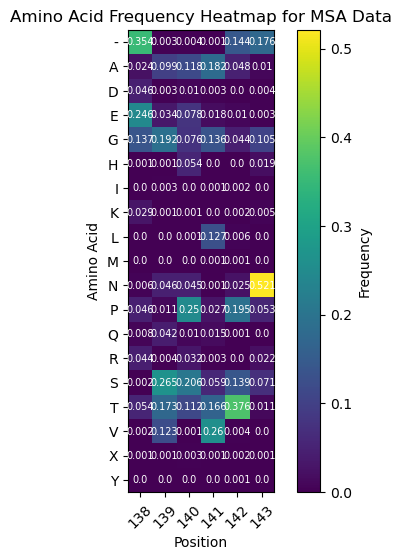

In [18]:
evaluator.heatmap_plot_aa_frequencies()

In [19]:
paths_mutation_matches_by_mutation = evaluator.get_metrics_by_mutation(paths_mutation_matches,paths)
for i in range(num_of_paths):
    path_name = f"Path {i+1}"
    print(f"{path_name}: {paths_mutation_matches_by_mutation[path_name]}")

Path 1: [('S140K', 0.001), ('T141V', 0.26), ('T139P', 0.011), ('P139K', 0.001), ('V141D', 0.003), ('N142I', 0.002), ('I142T', 0.376)]
Path 2: [('S140K', 0.001), ('T141V', 0.26), ('T139P', 0.011), ('P139K', 0.001), ('V141D', 0.003), ('D141A', 0.182), ('N142T', 0.376)]
Path 3: [('S140K', 0.001), ('T141V', 0.26), ('T139P', 0.011), ('P139K', 0.001), ('V141D', 0.003), ('D141A', 0.182), ('K140A', 0.118)]
Path 4: [('S140K', 0.001), ('T141V', 0.26), ('T139P', 0.011), ('P139K', 0.001), ('K139Q', 0.042), ('K140H', 0.054), ('H140R', 0.032)]
Path 5: [('S140K', 0.001), ('T141V', 0.26), ('T139P', 0.011), ('P139K', 0.001), ('K139Q', 0.042), ('Q139A', 0.099), ('N142T', 0.376)]
Path 6: [('S140K', 0.001), ('T141V', 0.26), ('T139P', 0.011), ('P139K', 0.001), ('K139Q', 0.042), ('Q139A', 0.099), ('A139H', 0.001)]
Path 7: [('S140K', 0.001), ('D138T', 0.054), ('T139V', 0.123), ('V139E', 0.034), ('N142T', 0.376)]
Path 8: [('S140K', 0.001), ('D138T', 0.054), ('T139V', 0.123), ('K140A', 0.118), ('V139E', 0.034)

In [20]:
average_mf_nonzero = evaluator.get_average_proportion_of_paths_with_nonzero_values(paths_mutation_matches)
print(f"Average proportion of mutations with non-zero MF across all paths: {average_mf_nonzero}")

Average proportion of mutations with non-zero MF across all paths: 0.99


Median of median MFs across all paths: 0.042


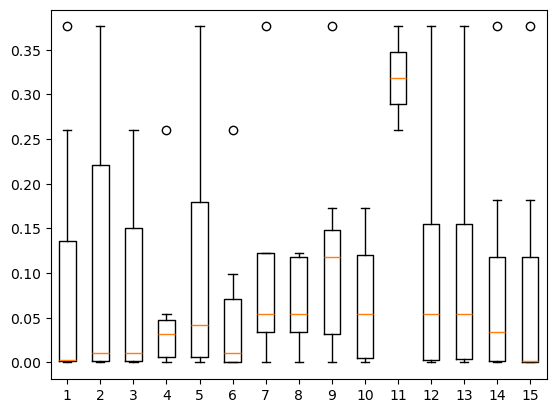

In [21]:
mf_medians = evaluator.get_box_plot_medians(paths_mutation_matches)
mf_median_of_medians = np.median(mf_medians)
print(f"Median of median MFs across all paths: {mf_median_of_medians}")

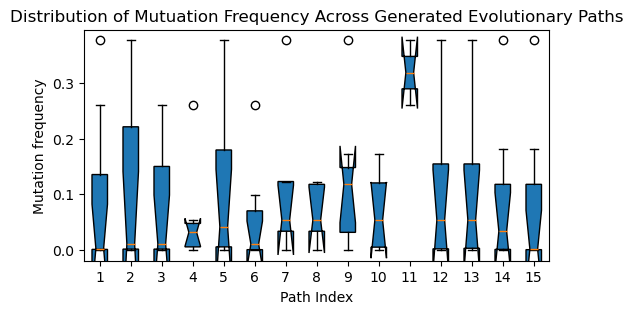

In [22]:
evaluator.box_plot_path_mutation_matches(paths_mutation_matches)

In [23]:
paths_pair_matches_by_mutation = evaluator.get_metrics_by_mutation(paths_consecutive_pair_matches,paths,pair=True)
for i in range(num_of_paths):
    path_name = f"Path {i+1}"
    print(f"{path_name}: {paths_pair_matches_by_mutation[path_name]}")

Path 1: [('S140K', 'T141V', 0.001), ('T141V', 'T139P', 0.0), ('T139P', 'P139K', 0.0), ('P139K', 'V141D', 0.0), ('V141D', 'N142I', 0.0), ('N142I', 'I142T', 0.0)]
Path 2: [('S140K', 'T141V', 0.001), ('T141V', 'T139P', 0.0), ('T139P', 'P139K', 0.0), ('P139K', 'V141D', 0.0), ('V141D', 'D141A', 0.0), ('D141A', 'N142T', 0.07)]
Path 3: [('S140K', 'T141V', 0.001), ('T141V', 'T139P', 0.0), ('T139P', 'P139K', 0.0), ('P139K', 'V141D', 0.0), ('V141D', 'D141A', 0.0), ('D141A', 'K140A', 0.011)]
Path 4: [('S140K', 'T141V', 0.001), ('T141V', 'T139P', 0.0), ('T139P', 'P139K', 0.0), ('P139K', 'K139Q', 0.0), ('K139Q', 'K140H', 0.007), ('K140H', 'H140R', 0.0)]
Path 5: [('S140K', 'T141V', 0.001), ('T141V', 'T139P', 0.0), ('T139P', 'P139K', 0.0), ('P139K', 'K139Q', 0.0), ('K139Q', 'Q139A', 0.0), ('Q139A', 'N142T', 0.031)]
Path 6: [('S140K', 'T141V', 0.001), ('T141V', 'T139P', 0.0), ('T139P', 'P139K', 0.0), ('P139K', 'K139Q', 0.0), ('K139Q', 'Q139A', 0.0), ('Q139A', 'A139H', 0.0)]
Path 7: [('S140K', 'D138T',

In [24]:
average_cmc_nonzero = evaluator.get_average_proportion_of_paths_with_nonzero_values(paths_consecutive_pair_matches)
print(f"Average proportion of mutations with non-zero MF across all paths: {average_cmc_nonzero}")

Average proportion of mutations with non-zero MF across all paths: 0.48


Median of median CMCs across all paths: 0.0


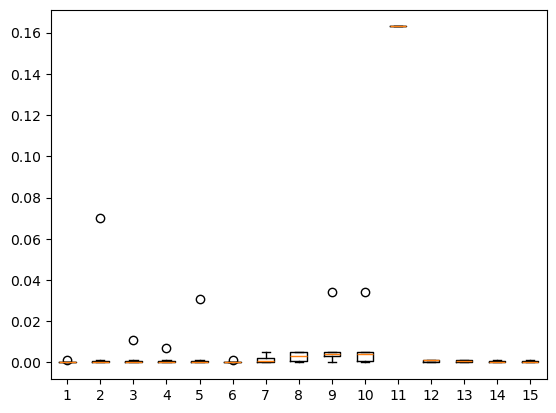

In [25]:
mf_medians = evaluator.get_box_plot_medians(paths_consecutive_pair_matches)
mf_median_of_medians = np.median(mf_medians)
print(f"Median of median CMCs across all paths: {mf_median_of_medians}")

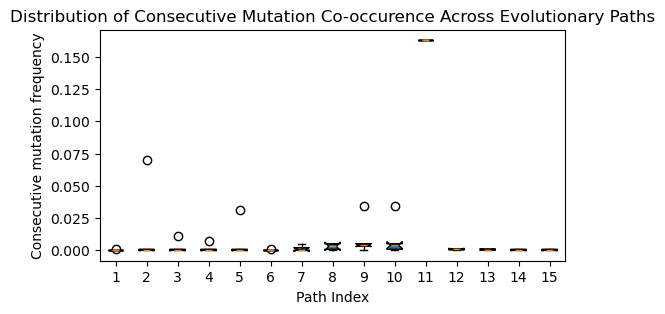

In [26]:
evaluator.box_plot_path_consecutive_pair_matches(paths_consecutive_pair_matches)

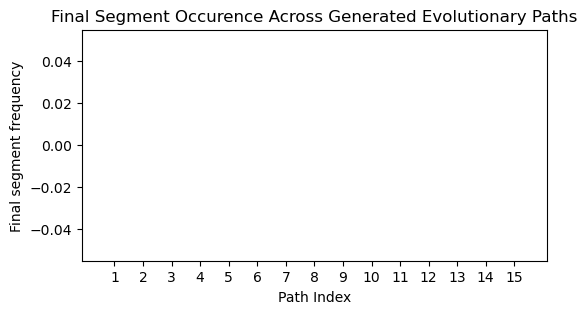

In [27]:
evaluator.bar_plot_path_final_segment_matches(paths_final_segment_matches)

In [28]:
# prior to changing should_continue_mutating from checking if sequence probability is increasing to checking if overall mutatioon score is increasing and using the minimum average logit score per position rather than the minimum aa logit value
# experiment observation: constraining positions for mutation increases length of evolution path  
# this is not surprising as mutating the position least favoured by the PLM != mutating the position that will yield an increase in sequence probability 
# replacing the current amino acid at the lowest logit position does not automatically increase the sequence probability 
# this is because it may choose a position where mutations are unlikely to happen at to begin  with (ie highly conserved regions) 
# thus leading to an overall decrease on the sequence probability and structure similarity
# When mutations are contrained to positions we know are highly variable from observed data, this aligns with the PLM's knowledge of existing mutations
# such that mutating these highly variable position can lead to higher probability sequences as it expects mutations to occur in these positions